### Import libraries and read in file

In [1]:
# import libs
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

In [2]:
# read in file and define some useful column groupings
elec_w_weather_path = '/users/ianmyjer/desktop/disagg/electric_data_with_weather.csv'
df = pd.read_csv(elec_w_weather_path,delimiter=',',header=0,index_col=0,parse_dates=True)

In [3]:
# define useful column groupings
power_cols = ['north_br','south_br','basement','dryer','washer',
'dining_room','dishwasher','workbench','security_system',
'refrigerator','furnace_fan','garage','heat_pump',
'dhw_heater','main_house_total','office','outside_plug',
'rental_suite','entertainment','utility_room','unmetered',
'whole_house_total','oven']
weather_cols = ['Temp (C)', 'Dew Point Temp (C)', 'Rel Hum (%)', 
'Wind Spd (km/h)','Stn Press (kPa)']

### X Vars

In [4]:
# time-based features
df['dow'] = df.index.weekday
df['weekday'] = (df.index.weekday < 5)*1
df['business_hours'] = (df.index.weekday < 5)&(df.index.hour>=9)&(df.index.hour<=17)*1
df['hour'] = df.index.hour

In [5]:
# season dummies
df['winter'] = (df.index.month<=3)*1
df['spring'] = (df.index.month>3)&(df.index.month<=6)*1
df['summer'] = (df.index.month>6)&(df.index.month<=9)*1
df['fall'] = (df.index.month>9)*1

In [6]:
# main house power percentage change 1 min intervals
df['pos_mht_pct'] = df['main_house_total'].pct_change(freq='1Min')
df['pos_mht_pct'].dropna(axis=0,inplace=True)

df['neg_mht_pct'] = df['main_house_total'].pct_change(freq='-1Min')
df['neg_mht_pct'].dropna(axis=0,inplace=True)

In [7]:
# main hosue power difference 1 min intervals
df['pos_mht_diff'] = df['main_house_total'].diff(periods=1)
df['pos_mht_diff'].dropna(axis=0,inplace=True)

df['neg_mht_diff'] = df['main_house_total'].diff(periods=-1)
df['neg_mht_diff'].dropna(axis=0,inplace=True)

In [8]:
df[['main_house_total','neg_mht_pct']].head()

,main_house_total,neg_mht_pct
ts,,
2012-04-01 07:00:00,873,0.003448
2012-04-01 07:01:00,870,0.051995
2012-04-01 07:02:00,827,0.000000
2012-04-01 07:03:00,827,0.134431
2012-04-01 07:04:00,729,-0.127990


### Category 1 - ON/OFF Appliances
Appliances that are either OFF and have 0 power draw or ON and have high power draw

In [9]:
of_apps = ['dishwasher', 'oven', 'dryer', 'washer']
df['of_apps_total'] = df[of_apps].sum(axis=1)
of_apps.append('of_apps_total')

In [62]:
# to identify when appliance starts
# value is positive
# neg percent change is big
# values in previous 5 mins were basically 0

for lbl in of_apps:
    lower_thresh = df[lbl][df[lbl]>0].quantile(0.25)
#     df[lbl+'_pos_pct_change']= df[lbl].pct_change(freq='1Min')
    df[lbl+'_rolling'] = df[lbl].rolling(20).sum().shift(1)
    crit = (df[lbl] > lower_thresh)&(df[lbl]> df[lbl+'_rolling'])
    df[lbl+'_start'] = crit*1

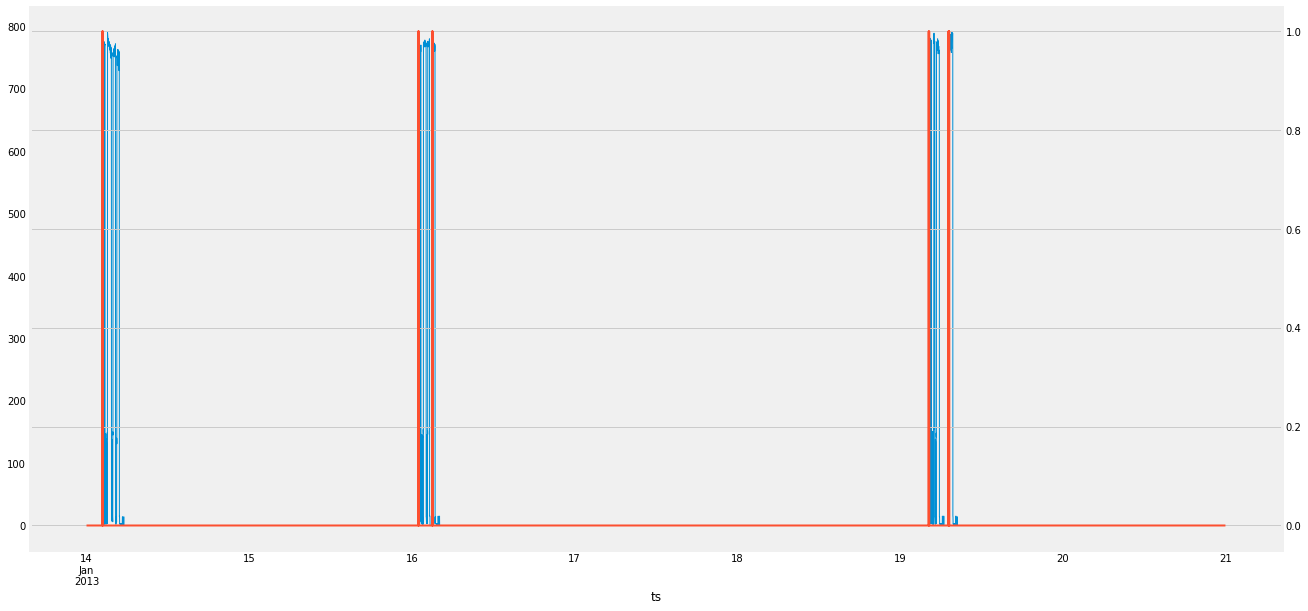

In [73]:
# plot to see if it makes sense
lbl = 'dishwasher'
mask = (df.index.week==3)&(df.index.year==2013) # &(df.index.day==15) # &(df.index.hour > 14)
df[lbl][mask].plot(linewidth=1,figsize=(20,10));
df[lbl+'_start'][mask].plot(secondary_y=True,linewidth=2,figsize=(20,10));

In some cases this methodology shows appliances turning on when they are not actually on (if power meter registers a non zero load for whatever reason). The methodology also shows appliances turning off midway through their usage (e.g., If the dishwasher has a small "off" period mid cycle) however, it seems like this basic methodology determines the power ON/OFF accurately most of the time (based on visual inspection).

I may need to revisit this if turns out to be whack. It would also be nice if I could quantify the accuracy of this methodology.

### Category 2 - ON/OFF Rooms
Rooms with switches that can be turned ON/OFF (lights, phone chargers, etc.)

When room is in use, power change is incremental and relatively small. For example, a bedroom could have a light turned on or a phone plugged in, but any increase or decrease in power would be small as compared to a dishwasher or dryer.

When all switches OFF, power may not be 0 due to plug loads (alarm clocks, safety lights, etc.)

In [75]:
all_of_rooms = ['north_br','south_br','basement','dining_room','workbench',
            'refrigerator','garage','office','outside_plug','rental_suite',
            'entertainment','utility_room']

mh_of_rooms = ['north_br','south_br','basement','dining_room','workbench',
            'refrigerator','office','outside_plug',
            'entertainment','utility_room']

df['all_of_rooms_total'] = df[all_of_rooms].sum(axis=1)
all_of_rooms.append('all_of_rooms_total')

df['mh_of_rooms_total'] = df[mh_of_rooms].sum(axis=1)
mh_of_rooms.append('mh_of_rooms_total')

for lbl in mh_of_rooms:
    df[lbl+'_on'] = df[lbl].apply(lambda x: 1 if x>5 else 0)

In [81]:
df['mh_of_rooms_total'].describe()# .loc['25%']

count    1.050780e+06
mean     2.503437e+02
std      1.809681e+02
min      0.000000e+00
25%      1.310000e+02
50%      2.050000e+02
75%      2.800000e+02
max      2.362000e+03
Name: mh_of_rooms_total, dtype: float64

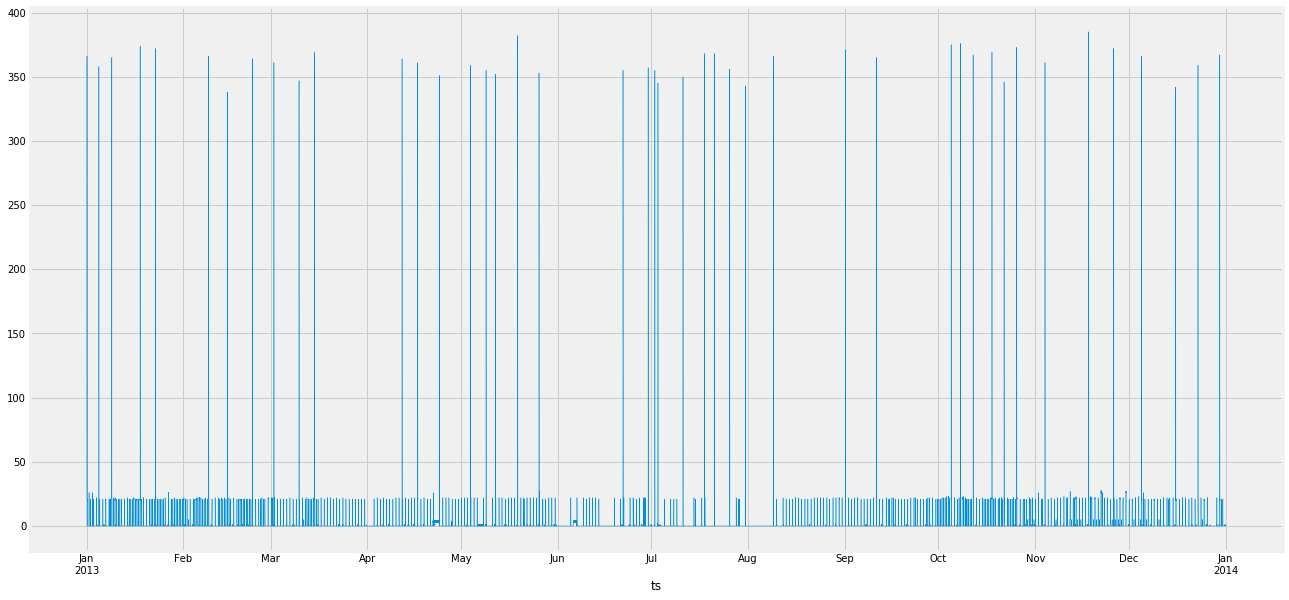

In [90]:
lbl = 'north_br'
ax = df[lbl][(df.index.year==2013)].plot(linewidth=0.5,figsize=(20,10));
# ax.set_ylim(-5,30)

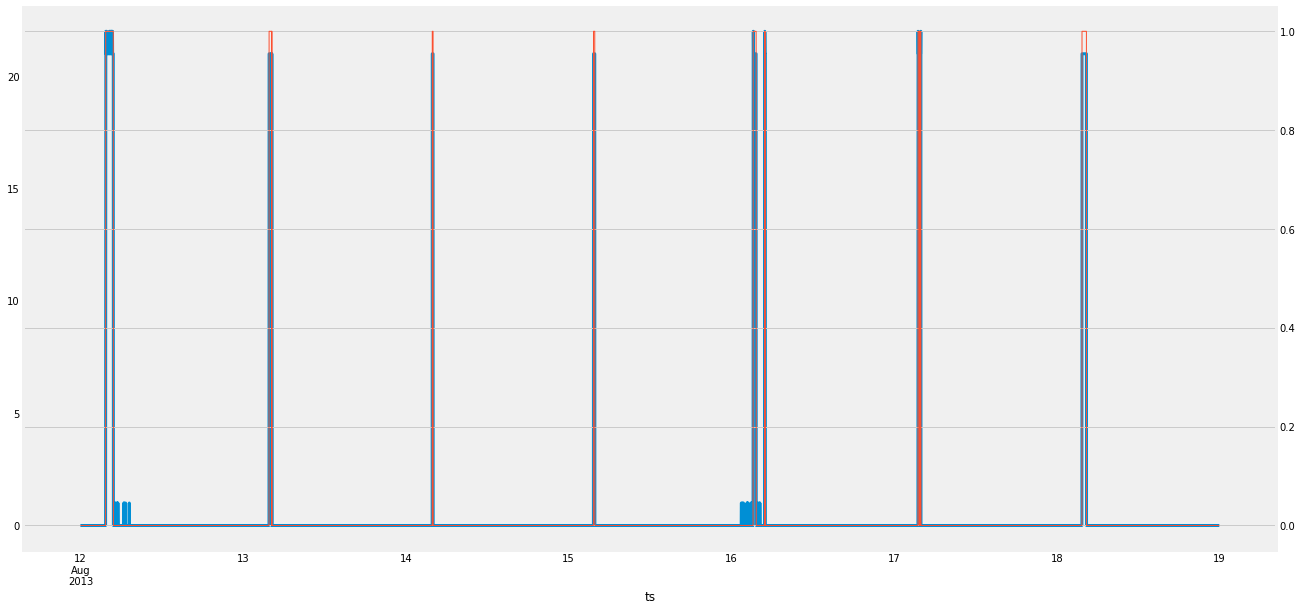

In [87]:
lbl = 'north_br'
mask = (df.index.week==33)&(df.index.year==2013)# &(df.index.day==12)
df[lbl][mask].plot(linewidth=3,figsize=(20,10));
df[lbl+'_on'][mask].plot(secondary_y=True,linewidth=1,figsize=(20,10));

### Category 3: On-Demand Appliances

Appliances that turn on and off automatically based on demand

In [ ]:
od_apps = ['dhw_heater','refrigerator']

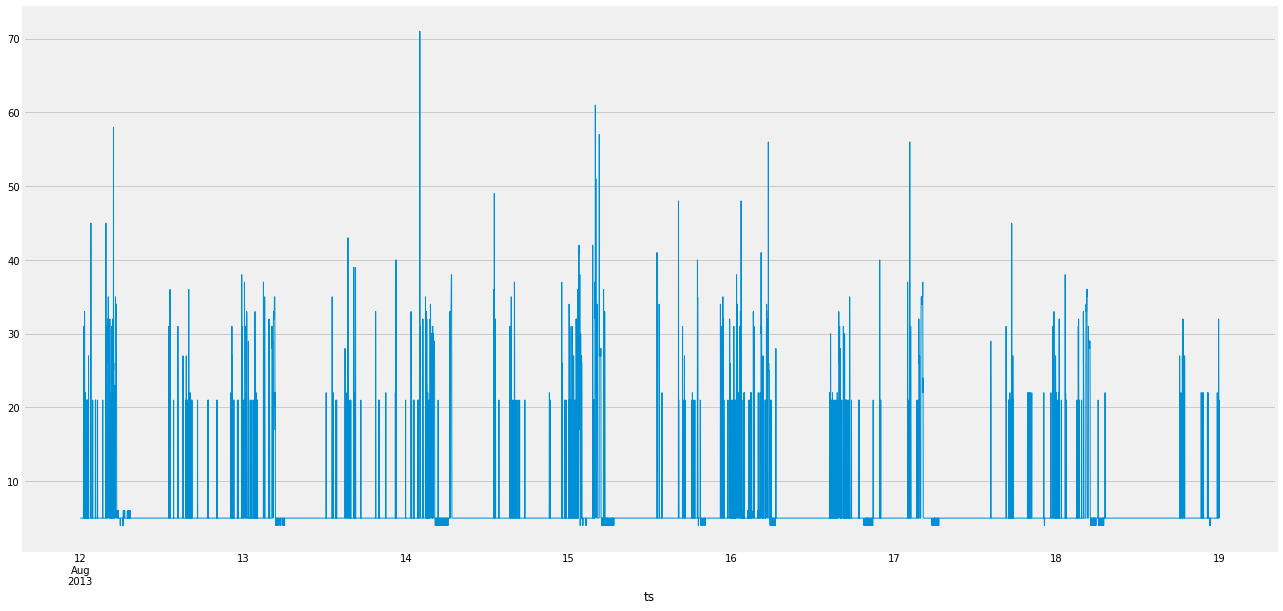

In [93]:
lbl = 'dhw_heater'
mask = (df.index.week==33)&(df.index.year==2013)# &(df.index.day==12)
df[lbl][mask].plot(linewidth=1,figsize=(20,10));
# df[lbl+'_on'][mask].plot(secondary_y=True,linewidth=1,figsize=(20,10));

### Category 4: Weather dependent appliances

Appliances that run automatically and may draw power based on the outdoor weather

In [101]:
wd_apps = ['furnace_fan','heat_pump']

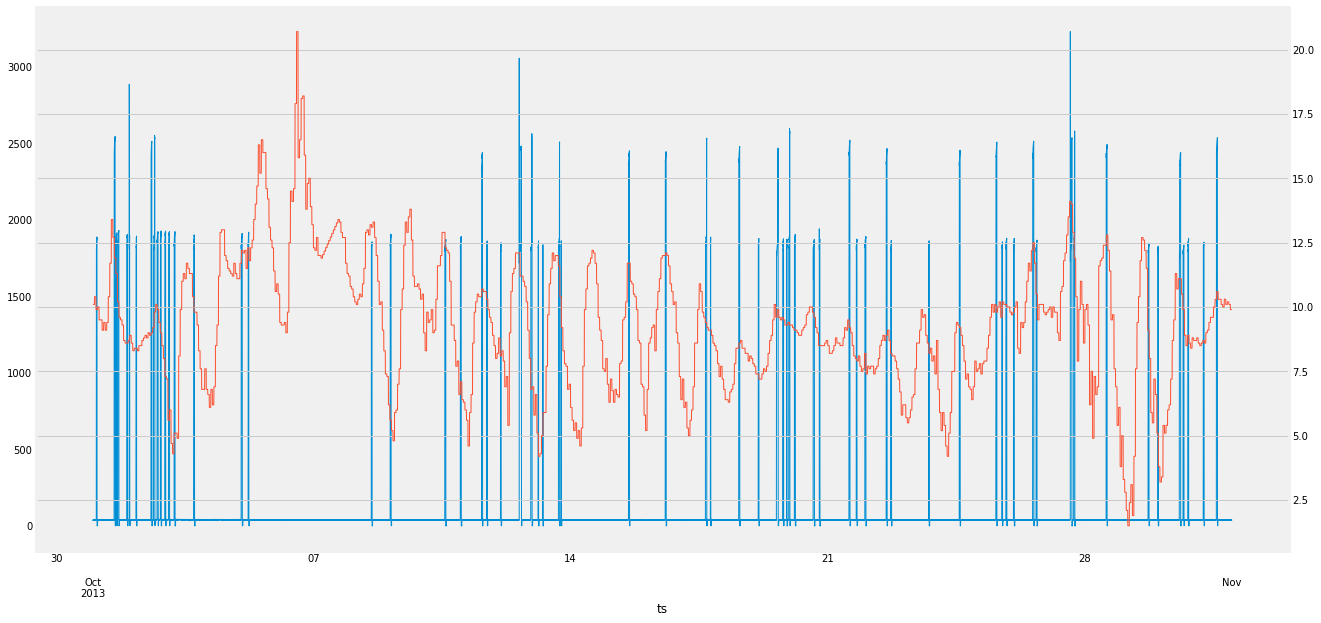

In [117]:
lbl = 'heat_pump'
mask = (df.index.month==10)&(df.index.year==2013)# &(df.index.day==12)
df[lbl][mask].plot(linewidth=1,figsize=(20,10));
df['Temp (C)'][mask].plot(secondary_y=True,linewidth=1,figsize=(20,10))
# df[lbl+'_on'][mask].plot(secondary_y=True,linewidth=1,figsize=(20,10));